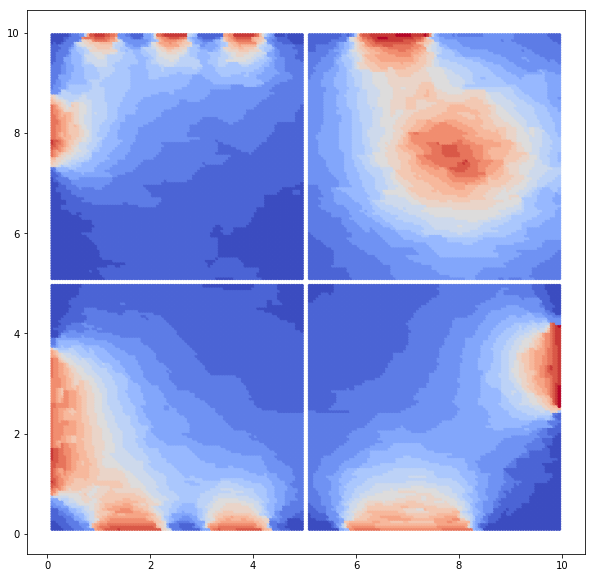

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import json

results_files = [
    "/Users/Tristan/Desktop/SAMAzure/TestFiles/HoneybeeRecipeJSONs/zone1_results.json",
    "/Users/Tristan/Desktop/SAMAzure/TestFiles/HoneybeeRecipeJSONs/zone2_results.json",
    "/Users/Tristan/Desktop/SAMAzure/TestFiles/HoneybeeRecipeJSONs/zone3_results.json",
    "/Users/Tristan/Desktop/SAMAzure/TestFiles/HoneybeeRecipeJSONs/zone4_results.json"
]

X = []
Y = []
Z = []
DF = []
for res in results_files:
    with open(res) as data_file:
        results = json.load(data_file)
    X.append(results["X"])
    Y.append(results["Y"])
    Z.append(results["Z"])
    DF.append(results["DF"])

    
X = [item for sublist in X for item in sublist]
Y = [item for sublist in Y for item in sublist]
Z = [item for sublist in Z for item in sublist]
DF = [item for sublist in DF for item in sublist]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(X, Y, c=DF, cmap="coolwarm", s=8)
    

In [ ]:
# Visualise the Radiance Geometry (from the geometry.json)
% matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

fig = plt.figure(figsize=(15, 7.5))
ax = Axes3D(fig)
xs, ys, zs = list(zip(*[item for sublist in [srf["vertices"][0] for srf in load_json("TESTTESTTEST/geometry.json")["surfaces"]] for item in sublist]))# ax.set_xlim([min(xs), max(xs)])
ax.set_ylim([min(ys), max(ys)])
ax.set_zlim([min(zs), max(zs)])

for srf in load_json("TESTTESTTEST/geometry.json")["surfaces"]:
    if srf["surface_type"] == 0:
        col = (0, 0, 1, 0.1)
    elif srf["surface_type"] == 1:
        col = (0, 1, 0, 0.1)
    elif srf["surface_type"] == 2:
        col = (1, 0, 0, 0.1)
    elif srf["surface_type"] == 3:
        col = (1, 1, 0, 0.1)
    elif srf["surface_type"] == 4:
        col = (0, 1, 1, 0.1)
    elif srf["surface_type"] == 5:
        col = (1, 1, 1, 0.1)

    [ax.add_collection3d(Poly3DCollection([srf["vertices"][0]], facecolor=col, edgecolor="w", zorder=0))]

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

axisEqual3D(ax)